In [1]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [1]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [2]:
import pandas as pd
import numpy as np
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.ensemble import IsolationForest
from tqdm import tqdm
import torch.optim as optim


# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch.nn as nn

In [3]:
# 데이터 로딩 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): csv 파일의 경로.
            transform (callable, optional): 샘플에 적용될 Optional transform.
        """
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df['img_path'].iloc[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        target = torch.tensor([0.]).float()
        return image, target

# 이미지 전처리 및 임베딩
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = CustomDataset(csv_file='../data/train.csv', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)

test_data = CustomDataset(csv_file='../data/test.csv', transform=transform)
test_loader = DataLoader(test_data, batch_size=32 ,shuffle=False)

In [4]:
# ResNet 모델을 특징 추출기로 사용
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        # ResNet의 마지막 fc 레이어를 제외한 모든 레이어를 가져옵니다.
        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x



class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # 인코더 정의
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, encoding_dim),
            nn.ReLU(True)
        )
        # 디코더 정의
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# ResNet101 모델 로드 및 특징 추출기 생성
resnet_model = models.resnet18(pretrained=True)
feature_extractor = FeatureExtractor(resnet_model).to(device)

# Autoencoder 모델 생성
autoencoder = Autoencoder(input_dim=512, encoding_dim=256).to(device)

C:\Users\SJ\anaconda3\envs\study\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\SJ\anaconda3\envs\study\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# ResNet101 모델 로드 및 특징 추출기 생성
resnet_model = models.resnet18(pretrained=True)
feature_extractor = FeatureExtractor(resnet_model).to(device)

# Autoencoder 모델 생성
autoencoder = Autoencoder(input_dim=512, encoding_dim=256).to(device)

In [6]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_autoencoder(model, train_loader, criterion, optimizer, scheduler, num_epochs=100):
    model.train()
    best_loss = None

    for epoch in range(num_epochs):
        total_loss = 0
        for images, _ in train_loader:
            images = images.to(device)

            # 특징 추출
            features = feature_extractor(images)
            # Autoencoder를 통한 재구성
            reconstructed = model(features)
            # 재구성 손실 계산
            loss = criterion(reconstructed, features)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # 평균 손실 계산
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

        # scheduler.step()에 평균 손실 전달
        scheduler.step(avg_loss)

        # Early stopping 조건 확인
        if best_loss is None or avg_loss < best_loss:
            best_loss = avg_loss
        else:
            print("No improvement in loss. Adjusting learning rate...")
            # 학습률 조정 로그는 ReduceLROnPlateau의 verbose=True를 통해 출력됩니다.

In [7]:

# Autoencoder 모델, 손실 함수, 옵티마이저 설정
autoencoder_criterion = nn.MSELoss()
autoencoder_optimizer = optim.AdamW(autoencoder.parameters(), lr=0.001)
autoencoder_scheduler = ReduceLROnPlateau(autoencoder_optimizer, mode='min', factor=0.1, patience=10, verbose=True)


# # Autoencoder 모델 학습
# train_autoencoder(autoencoder, train_loader, autoencoder_criterion, autoencoder_optimizer,autoencoder_scheduler)

C:\Users\SJ\anaconda3\envs\study\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [8]:
train_autoencoder(autoencoder, train_loader, autoencoder_criterion, autoencoder_optimizer, autoencoder_scheduler)

Epoch 1/100, Loss: 0.1479
Epoch 2/100, Loss: 0.0834
Epoch 3/100, Loss: 0.0834
No improvement in loss. Adjusting learning rate...
Epoch 4/100, Loss: 0.0834
No improvement in loss. Adjusting learning rate...
Epoch 5/100, Loss: 0.0834
No improvement in loss. Adjusting learning rate...
Epoch 6/100, Loss: 0.0834
No improvement in loss. Adjusting learning rate...
Epoch 7/100, Loss: 0.0834
No improvement in loss. Adjusting learning rate...
Epoch 8/100, Loss: 0.0834
No improvement in loss. Adjusting learning rate...
Epoch 9/100, Loss: 0.0834
No improvement in loss. Adjusting learning rate...
Epoch 10/100, Loss: 0.0834
No improvement in loss. Adjusting learning rate...
Epoch 11/100, Loss: 0.0834
No improvement in loss. Adjusting learning rate...
Epoch 12/100, Loss: 0.0834
No improvement in loss. Adjusting learning rate...


KeyboardInterrupt: 

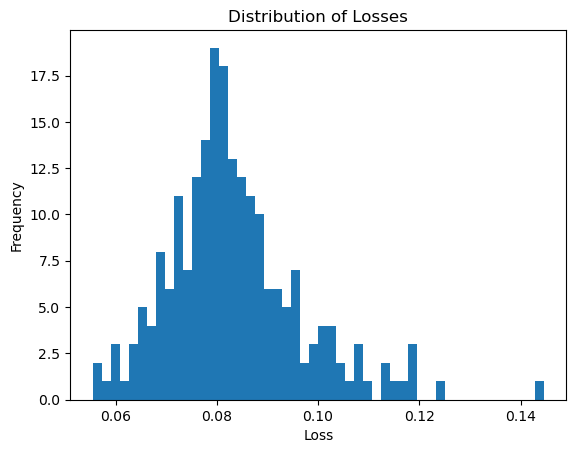

In [9]:
import matplotlib.pyplot as plt

def calculate_losses(train_loader, model):
    model.eval()  # 평가 모드 전환
    losses = []  # 손실 초기화
    with torch.no_grad():
        for images, _ in train_loader:
            images = images.to(device)
            features = feature_extractor(images)
            reconstructed = model(features)
            loss = nn.MSELoss(reduction='none')(reconstructed, features).mean(1)  # 손실 계산
            losses.extend(loss.cpu().numpy())
    return losses

# 학습 데이터의 손실 계산
losses = calculate_losses(train_loader, autoencoder)

# 손실 분포 시각화
plt.hist(losses, bins=50)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Losses')
plt.show()

In [10]:
# 손실 값의 상위 95%에 해당하는 분위수를 임계값으로 설정
threshold = np.quantile(losses, 0.95)
print(f"Threshold for anomaly detection: {threshold}")

Threshold for anomaly detection: 0.10863772630691527


In [44]:
threshold= 0.0826

In [45]:
# 제출 파일 로드
submit = pd.read_csv('../submission/sample_submission.csv')

def detect_anomalies(loader, model, threshold):
    model.eval()
    anomaly_scores = []
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            features = feature_extractor(images)
            reconstructed = model(features)
            loss = torch.mean((features - reconstructed) ** 2, dim=1)
            anomaly_scores.extend(loss.cpu().numpy())
    return anomaly_scores



# 이상 탐지 수행 및 anomaly_scores 계산
anomaly_scores = detect_anomalies(test_loader, autoencoder, threshold)

# anomaly_scores를 사용하여 정상(0) 또는 이상(1) 레이블 결정
submit['label'] = [1 if score > threshold else 0 for score in anomaly_scores]

# 변경된 submit DataFrame 확인
submit

,id,label
0,TEST_000,1
1,TEST_001,0
2,TEST_002,0
3,TEST_003,1
4,TEST_004,0
...,...,...
95,TEST_095,0
96,TEST_096,0
97,TEST_097,0
98,TEST_098,0


In [46]:
submit['label'].sum()

41

In [145]:
submission = pd.read_csv("../submission/sample_submission.csv")
submission['label'] = anomaly_labels

In [146]:
submission

,id,label
0,TEST_000,1
1,TEST_001,0
2,TEST_002,1
3,TEST_003,0
4,TEST_004,1
...,...,...
95,TEST_095,1
96,TEST_096,0
97,TEST_097,1
98,TEST_098,0


In [323]:
submission.to_csv("../submission/submission_3.csv",index = False)

NameError: name 'submission' is not defined

In [47]:
submit.to_csv("../submission/submission_4.csv",index = False)